# Utility measures for synthetic data before and after the anonymization algorithm is applied.

In [1]:
import pandas as pd
import numpy as np
import itertools

from pointpats import PointPattern
from pointpats.distance_statistics import L

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing

from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt

from scipy.spatial import cKDTree

from pyproj import Proj
from geopy.geocoders import Nominatim

C:\Users\Cameron\anaconda3\lib\site-packages\libpysal\weights\util.py:23: UserWarning: geopandas not available. Some functionality will be disabled.
  warn("geopandas not available. Some functionality will be disabled.")


In [2]:
train_data = pd.read_csv("Data/synthetic_datasets/synthetic_holdouts/train_dataset.csv")

In [3]:
holdout_data = pd.read_csv("Data/synthetic_datasets/synthetic_holdouts/val_dataset.csv")

In [4]:
sXs_mnl = [pd.read_csv("Data/synthetic_datasets/synthetic_holdouts/synthetic_dataset_" + str(i) + ".csv") for i in range(20)]

In [5]:
sXs_cart = [pd.read_csv("Data/synthetic_datasets/synthetic_holdouts/cart_synthetic_dataset_" + str(i) + ".csv") for i in range(20)]

In [6]:
sXs_mostly = [pd.read_csv("Data/synthetic_datasets/synthetic_holdouts/mostly_synthetic_train_" + str(i) + ".csv") for i in range(20)]

***

## Utility Measure 1 - pMSE Ratios

In [7]:
def cart_pmse_ratio(original_data, synthetic_data_sets):
    
    null_pmse_list = []
    
    inds = np.arange(len(synthetic_data_sets))
    
    combo_list = list(itertools.combinations(inds, 2))
    
    for combo in combo_list:
    
        s1 = synthetic_data_sets[combo[0]]
        s2 = synthetic_data_sets[combo[1]]
    
        N_orig = s1.shape[0]
        N_synth = s2.shape[0]
    
        c = N_synth/(N_synth+N_orig)
    
        full_X = pd.concat([s1, s2], axis=0).reset_index(drop=True)
    
        full_X = preprocessing.StandardScaler().fit_transform(full_X)

        y = np.repeat([0, 1], repeats=[N_orig, N_synth])
    
        cart = DecisionTreeClassifier(min_samples_split=20,
                                      min_samples_leaf=int(np.round(20/3)),
                                      ccp_alpha=0.0001,
                                      max_depth=30)
    
        cart.fit(X=full_X, y=y)
    
        probs = cart.predict_proba(full_X)
    
        pMSE = 1/(N_synth + N_orig) * np.sum((probs[:,1] - c)**2)
        
        null_pmse_list.append(pMSE)
    
    pmse_list = []
    
    for s in synthetic_data_sets:
    
        N_orig = original_data.shape[0]
        N_synth = s.shape[0]
    
        c = N_synth/(N_synth+N_orig)
    
        full_X = pd.concat([original_data, s], axis=0).reset_index(drop=True)
    
        full_X = preprocessing.StandardScaler().fit_transform(full_X)

        y = np.repeat([0, 1], repeats=[N_orig, N_synth])
    
        cart = DecisionTreeClassifier(min_samples_split=20,
                                      min_samples_leaf=int(np.round(20/3)),
                                      ccp_alpha=0.0001,
                                      max_depth=30)
    
        cart.fit(X=full_X, y=y)
    
        probs = cart.predict_proba(full_X)
    
        pMSE = 1/(N_synth + N_orig) * np.sum((probs[:,1] - c)**2)
        
        pmse_list.append(pMSE)
        
    return np.array(pmse_list)/np.mean(null_pmse_list)

In [8]:
def pmse_ratio(original_data, synthetic_data):
    
    N_synth = synthetic_data.shape[0]
    N_orig = original_data.shape[0]
    
    # combine original and synthetic datasets
    full_X = pd.concat([original_data, synthetic_data], axis=0).reset_index(drop=True)
    
    full_X["age"] = full_X["age"].astype('category')
    
    age_dummies = pd.get_dummies(full_X['age'], drop_first=True)
    
    age_dummies.columns = [str(x) for x in age_dummies.columns]
    
    full_X = full_X.drop("age", axis=1)
    
    full_X = pd.concat([full_X, age_dummies], axis=1)
    
    # generate interactions and powers of variables
    poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)
    
    full_X = poly.fit_transform(full_X)
    
    full_X = full_X[:,:-36]

    # scale the combined dataset
    full_X = preprocessing.StandardScaler().fit_transform(full_X)
    
    c = N_synth/(N_synth+N_orig)

    y = np.repeat([0, 1], repeats=[N_orig, N_synth])
    
    pMSE_model = LogisticRegression(penalty='none', max_iter=1000).fit(full_X, y)
    
    probs = pMSE_model.predict_proba(full_X)
    
    pMSE = 1/(N_synth+N_orig) * np.sum((probs[:,1] - c)**2)
    
    e_pMSE = 2*(full_X.shape[1])*(1-c)**2 * c/(N_synth+N_orig)
        
    return pMSE/e_pMSE

In [9]:
pmse_ratio(train_data, holdout_data)

1.0406155684790837

In [10]:
# ratios = [pmse_ratio(train_data, Y) for Y in sXs_mnl]
ratios = cart_pmse_ratio(train_data, sXs_mnl)
np.mean(ratios)

1.2301024056392744

In [11]:
# cart_ratios = [pmse_ratio(train_data, Y) for Y in sXs_cart]
cart_ratios = cart_pmse_ratio(train_data, sXs_cart)
np.mean(cart_ratios)

1.094627337559626

In [12]:
# mostly_ratios = [pmse_ratio(train_data, Y) for Y in sXs_mostly]
mostly_ratios = cart_pmse_ratio(train_data, sXs_mostly)
np.mean(mostly_ratios)

1.238924919806442

In [13]:
# ratios_holdout = [pmse_ratio(holdout_data, Y) for Y in sXs_mnl]
ratios_holdout = cart_pmse_ratio(holdout_data, sXs_mnl)
np.mean(ratios_holdout)

1.6851251834121919

In [14]:
# cart_ratios_holdout = [pmse_ratio(holdout_data, Y) for Y in sXs_cart]
cart_ratios_holdout = cart_pmse_ratio(holdout_data, sXs_cart)
np.mean(cart_ratios_holdout)

1.422900264372553

In [15]:
# mostly_ratios_holdout = [pmse_ratio(holdout_data, Y) for Y in sXs_mostly]
mostly_ratios_holdout = cart_pmse_ratio(holdout_data, sXs_mostly)
np.mean(mostly_ratios_holdout)

1.5358626158327084

***

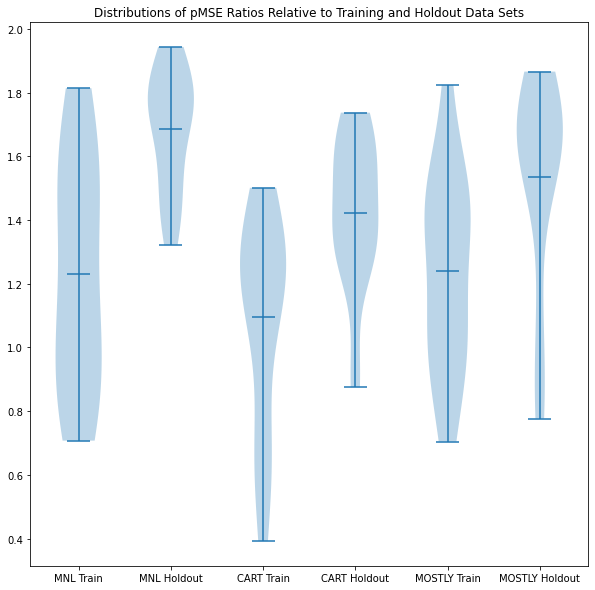

In [16]:
# Combine data
plot_data = list([ratios, ratios_holdout, cart_ratios, cart_ratios_holdout, mostly_ratios, mostly_ratios_holdout])

fig, ax = plt.subplots(figsize=(10,10))

xticklabels = ["MNL Train", "MNL Holdout", "CART Train", "CART Holdout", "MOSTLY Train", "MOSTLY Holdout"]
ax.set_xticks([1, 2, 3, 4, 5, 6])
ax.set_xticklabels(xticklabels)

ax.violinplot(plot_data, showmeans=True)

plt.title("Distributions of pMSE Ratios Relative to Training and Holdout Data Sets")

plt.show()

***

## Utility Measure 2 - K and L Functions

Calculate L function for original and synthetic datasets and plot.

In [17]:
# L function value for original data
l_orig = L(PointPattern(train_data.loc[:,['latitude', 'longitude']])).l

In [18]:
# L function values for synthetic data
l_synth = [L(PointPattern(Y.loc[:,['latitude', 'longitude']])).l for Y in sXs_mnl]

In [19]:
# L function values for MOSTLY.AI synthetic data
l_mostly = [L(PointPattern(Y.loc[:,['latitude', 'longitude']])).l for Y in sXs_mostly]

In [20]:
# L function values for anonymized synthetic data
l_synth_cart = [L(PointPattern(Y.loc[:,['latitude', 'longitude']])).l for Y in sXs_cart]

In [21]:
pos_sXs = [Y.loc[Y.state==1.0,:] for Y in sXs_mnl]

In [22]:
pos_sXs_cart = [Y.loc[Y.state==1.0,:] for Y in sXs_cart]

In [23]:
pos_sXs_mostly = [Y.loc[Y.state==1.0,:] for Y in sXs_mostly]

In [24]:
pos_l_orig = L(PointPattern(train_data.loc[train_data.state==1.0,["latitude", "longitude"]])).l

In [25]:
pos_l_synth = [L(PointPattern(Y.loc[:,["latitude", "longitude"]])).l for Y in pos_sXs]

In [26]:
pos_l_synth_cart = [L(PointPattern(Y.loc[:,["latitude", "longitude"]])).l for Y in pos_sXs_cart]

In [27]:
pos_l_synth_mostly = [L(PointPattern(Y.loc[:,["latitude", "longitude"]])).l for Y in pos_sXs_mostly]

In [28]:
def L_plot(ax1, line_orig, line_synthetic, plot_title):
    
    # x values to plot
    x = np.arange(0, 1.2, 0.1)
    
    # average L function for synthetic data
    synthetic_mean = np.mean(line_synthetic, axis=0)

    # calculate 95% empirical confidence interval for L function value for synthetic data
    qs = np.quantile(line_synthetic, (0.025, 0.975), axis=0)
    
    ax1.plot(x, line_orig, label = 'Original')
    ax1.plot(x, synthetic_mean, label = 'Avg Synthetic')
    ax1.fill_between(x, qs[0,:], qs[1,:], alpha = 0.3)
    ax1.legend(loc = 'lower right')
    ax1.set_title(plot_title)
    ax1.set_xlabel('h')
    ax1.set_ylabel('L(h)')

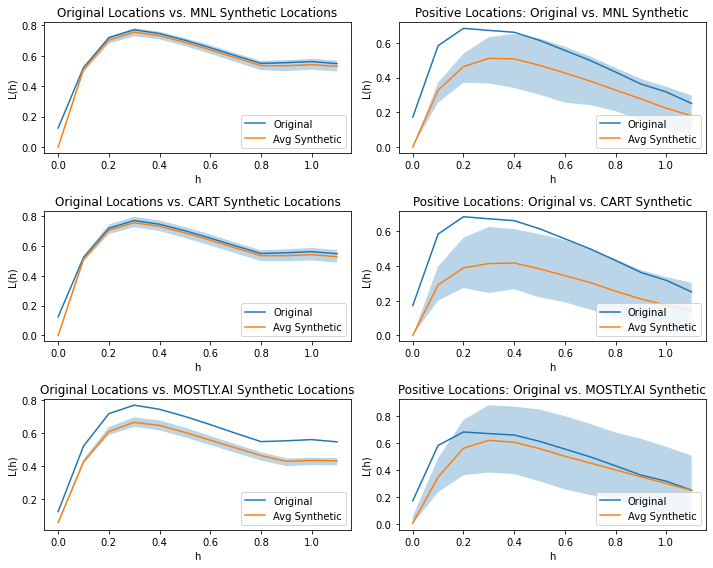

In [29]:
fig, ax = plt.subplots(3, 2, figsize=(10,8))
L_plot(ax[0,0], l_orig, l_synth, "Original Locations vs. MNL Synthetic Locations")
L_plot(ax[0,1], pos_l_orig, pos_l_synth, "Positive Locations: Original vs. MNL Synthetic")
L_plot(ax[1,0], l_orig, l_synth_cart, "Original Locations vs. CART Synthetic Locations")
L_plot(ax[1,1], pos_l_orig, pos_l_synth_cart, "Positive Locations: Original vs. CART Synthetic")
L_plot(ax[2,0], l_orig, l_mostly, "Original Locations vs. MOSTLY.AI Synthetic Locations")
L_plot(ax[2,1], pos_l_orig, pos_l_synth_mostly, "Positive Locations: Original vs. MOSTLY.AI Synthetic")
plt.tight_layout()

# Utility Measure 3: Visual Comparison of Locations

Visual comparison of location distributions.

In [37]:
def scatter_plot(ax1, location_data, plot_title, xlab, ylab):
    
    ax1.scatter(location_data.longitude, location_data.latitude)
    
    ax1.set_title(plot_title)
    ax1.set_xlabel(xlab)
    ax1.set_ylabel(ylab)
#     ax1.plot(x, synthetic_mean, label = 'Avg Synthetic')
#     ax1.fill_between(x, qs[0,:], qs[1,:], alpha = 0.3)
#     ax1.legend(loc = 'lower right')
#     ax1.set_title(plot_title)
#     ax1.set_xlabel('h')
#     ax1.set_ylabel('L(h)')

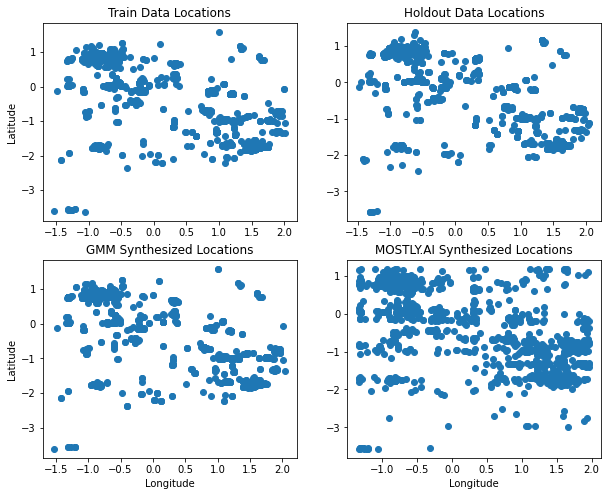

In [38]:
fig, ax = plt.subplots(2, 2, figsize=(10,8))
scatter_plot(ax[0,0], train_data, "Train Data Locations", "", "Latitude")
scatter_plot(ax[0,1], holdout_data, "Holdout Data Locations", "", "")
scatter_plot(ax[1,0], sXs_mnl[0], "GMM Synthesized Locations", "Longitude", "Latitude")
scatter_plot(ax[1,1], sXs_mostly[0], "MOSTLY.AI Synthesized Locations", "Longitude", "")

***

Look at plots of the points with positive mark values.

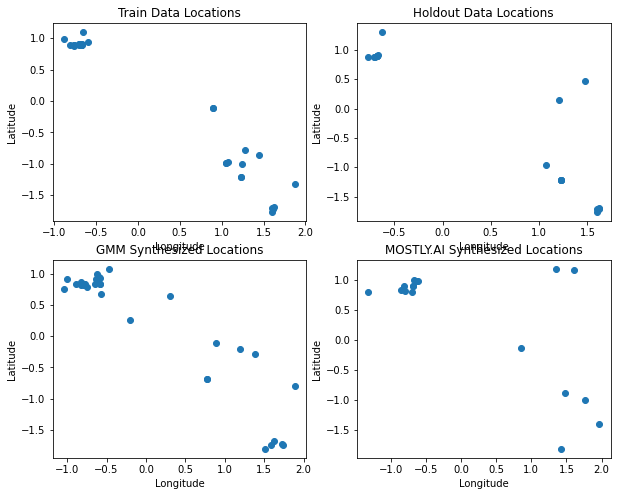

In [35]:
fig, ax = plt.subplots(2, 2, figsize=(10,8))
scatter_plot(ax[0,0], train_data.loc[train_data.state==1.0,:], "Train Data Locations")
scatter_plot(ax[0,1], holdout_data.loc[holdout_data.state==1.0,:], "Holdout Data Locations")
scatter_plot(ax[1,0], sXs_mnl[0].loc[sXs_mnl[0].state==1.0,:], "GMM Synthesized Locations")
scatter_plot(ax[1,1], sXs_mostly[0].loc[sXs_mostly[0].state==1.0,:], "MOSTLY.AI Synthesized Locations")

# Utility Measure 4: Absolute Deviations in Cross-Tabulations

Compare this to the utility metric given in the MOSTLY.AI code - I think this would be redundant.

Instead of zip codes, could try discretizing the continuous variables into bins and doing the cross-tabulations that way. Would probably be faster than obtaining zip codes for all the datasets. Check Monika's paper, I think they mention doing this.

Measure the deviations in relative frequencies within cross-tabulations of each variable.

Convert lat/long measurements to zip codes.

Write a function to convert lat/lon measurements into zipcodes.

In [ ]:
def get_zipcode(df, geolocator, lat_field, lon_field):
    location = geolocator.reverse((df[lat_field], df[lon_field]))
    return location.raw['address']

In [ ]:
def zip_generator(dataset, standardization_stats):
    
    # use to reverse meters into lat/lon
    p = Proj("epsg:5179")
    
    # use to get zip from lat/lon
    geolocator = Nominatim(user_agent='sk-zip-code-conversion')
    
    # reverse transform from meters to lat/lon
    locs = pd.concat([dataset.latitude * stan_stats.stds[0] + stan_stats.means[0], dataset.longitude * stan_stats.stds[1] + stan_stats.means[1]], axis=1)
    inverse_locs = pd.DataFrame(p(locs["longitude"], locs["latitude"], inverse=True)).T
    inverse_locs.columns = ["longitude", "latitude"]
    
    # get zips from lat/lon
    zipcodes = inverse_locs.apply(get_zipcode, axis=1, geolocator=geolocator, lat_field='latitude', lon_field='longitude')
    
    # use nearest neighbor locations to fill in missing zip codes
    no_code = ['postcode' not in x for x in zipcodes]
    has_code = ['postcode' in x for x in zipcodes]
    
    no_code_points = dataset.loc[no_code,["latitude","longitude"]]
    code_points = dataset.loc[has_code,["latitude","longitude"]]
    
    has_code_tree = cKDTree(code_points)
    dists, ids = has_code_tree.query(x=no_code_points, k=1, p=2.0)
    
    missing_zips = [zipcodes[i]['postcode'] for i in ids]
    zips = pd.Series([x['postcode'] if 'postcode' in x else 0 for x in zipcodes])
    zips[no_code_points.index] = missing_zips
    zips.name = "zip"
    
    new_dataset = pd.concat([dataset, zips], axis=1)
    
    return new_dataset

In [ ]:
stan_stats = pd.read_csv("Data/standardization_stats.csv")

In [ ]:
X = zip_generator(X, stan_stats)

## Start with One Way Tables

In [ ]:
def table_maker(data, row_vars, col_vars):
    
    tab = pd.crosstab([data[v] for v in row_vars], [data[v] for v in col_vars], normalize=True, dropna=False)
    
    return tab

Calculate baseline tables for original data.

In [ ]:
sX = sXs[0]

In [ ]:
age = table_maker(X, ['age', 'sex'], ['age'])
# state = table_maker(X.state, X.state)
# sex = table_maker(X.sex, X.sex)
# zip_code = table_maker(X.zip, X.zip)

In [ ]:
age

In [ ]:
s_age = table_maker(sX.age, sX.age)

In [ ]:
s_age

In [ ]:
age

In [ ]:
np.diag(age-s_age)

Get list of all zip codes in south korea, see if I can cross tabulate against that to account for possibly non-overlapping zip codes in the original and synthetic datasets.